In [1]:
import torch
import torch.nn as nn
batch_size = 16
# Your model's output logits, shape (batch_size, 4)
logits = torch.randn(batch_size, 4)  # Replace with your actual logits
print(f"logit shape {logits.shape}")
# Ground truth labels as class indices, shape (batch_size,)
labels = torch.randint(4, (batch_size,))  # Replace with your actual labels
print(f"logit shape {labels.shape}")
# Define the Cross-Entropy loss function
criterion = nn.CrossEntropyLoss()

# Compute the loss
loss = criterion(logits, labels)
print(loss)
print(f"loss shape {loss.shape}")

logit shape torch.Size([16, 4])
logit shape torch.Size([16])
tensor(1.7381)
loss shape torch.Size([])


In [2]:
predicted_labels = torch.argmax(logits, dim=1)
print(predicted_labels)
print(labels)

tensor([3, 3, 1, 3, 0, 2, 0, 3, 2, 2, 2, 1, 3, 0, 3, 2])
tensor([3, 1, 0, 0, 3, 0, 1, 3, 3, 2, 3, 1, 1, 3, 0, 2])


In [4]:
from sklearn.metrics import f1_score
correct_predictions = (predicted_labels == labels).sum().item()
accuracy = correct_predictions / batch_size
f1 = f1_score(labels, predicted_labels, average='weighted') 
print(accuracy)
print(f1)

0.3125
0.3010989010989011


In [5]:
import yaml

# Load the configuration from the YAML file
with open('config/config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)


In [6]:
from models.LSTM import LSTMDecoder
from models.Attention import EncoderLayer
from simple_parsing import ArgumentParser
import torch
import torch.nn
from Vocabulary import Vocabulary
from models.Graph_Model import GNNEncoder
args = config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = GNNEncoder(
    args = args,
    cg_layer = 3,
    tg_layer = 3,
    aggregate_method = "mean", 
    input_feat = 514,
    hidden_size = 128,
    output_size = 128,
)
decoder = LSTMDecoder(
    vocab_size = 119, 
    embed_size = 512, 
    hidden_size = 512,  
    batch_size= args["batch_size"], 
    bi_direction = args["lstm_param"]["bi_direction"],
    device = device,
    dropout = args["lstm_param"]["dropout"],
        num_layers = args["lstm_param"]["num_layers"]
    )


In [7]:
# print(list(encoder.softmax.parameters()))
# print(encoder.parameters)

encoder_parameters = filter(lambda p: p.requires_grad, encoder.parameters())
# Create a list of parameters, excluding the final softmax layer
parameters_to_optimize = [p for p in encoder_parameters if p is not encoder.softmax.weight and p is not encoder.softmax.bias]
# print(parameters_to_optimize)

In [8]:
import os
from Vocabulary import Vocabulary
from dataloader import make_dataloader
split = "train"
loader,_ = make_dataloader(
    batch_size = 2,
    split = split,
    base_data_path = "../../../../../../srv/scratch/bic/peter/Report",
    graph_path = "../../../../../../srv/scratch/bic/peter/full-graph",
    vocab_path = "vocab_bladderreport.pkl",
    shuffle=True,
    num_workers=4,
    load_in_ram = True
)
print(f"length data loader for {split} is {len(loader)}")

# for word, idx in loader.dataset.vocab.word2idx.items():
#     print(f"Word: {word}, Index: {idx}")
cg,tg,am,cap_to, label, cap, img = next(iter(loader))
print(img.shape)

length data loader for train is 5840
torch.Size([2, 3, 500, 500])


In [9]:
import torchvision
resnet34 = torchvision.models.resnet34(pretrained=True)
with torch.no_grad():
    output = resnet34(img)
print(output.shape)

/home/z5313504/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z5313504/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([2, 1000])


In [ ]:
!ls ../../../../../../srv/scratch/bic/peter/Report/Images

In [ ]:
from glob import glob 
all_img = glob(os.path.join("../../../../../../srv/scratch/bic/peter/Report/Images/train","*.png"))
print(len(all_img))
print(all_img[0])


In [ ]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
# Load the image using OpenCV
image = Image.open(all_img[0]).convert('RGB')
print(type(image))
print(image.size)

plt.imshow(image)  # OpenCV uses BGR format, so we convert it to RGB for Matplotlib
plt.title("Image")
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
import torchvision
resnet34 = torchvision.models.resnet34(pretrained=True)

In [ ]:
from torchvision import transforms
import torch
preprocess = transforms.Compose([
    transforms.Resize((500, 500)),  # Resize to the desired size
    transforms.ToTensor(),  # Convert to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet statistics
])

# Apply the preprocessing steps to the image
print(type(image))
input_tensor = preprocess(image)
print(input_tensor.shape)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension
with torch.no_grad():
    output = resnet34(input_batch)
print(output.shape)

### Example for nn.TransformerDecoder

In [13]:
import torch
import torch.nn as nn

# Define the parameters
d_model = 512  # Model dimension
nhead = 8     # Number of attention heads
num_layers = 6  # Number of decoder layers
dim_feedforward = 2048  # Feedforward dimension

# Create the decoder
dec = nn.TransformerDecoder(
    nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward),
    num_layers,
)

# Input and target sequences
tgt = torch.rand(10, 32, d_model)  # (sequence_length, batch_size, d_model)
memory = torch.rand(1, 32, d_model)  # (sequence_length, batch_size, d_model)

# Output from the decoder
output = dec(tgt, memory)
print(output.shape)

torch.Size([10, 32, 512])


## Transformers


In [3]:
from models.Graph_Model import GNNEncoder
from models.LSTM import LSTMDecoder
from models.GlobalFeatureExtractor import GlobalFeatureExtractor
from models.Classifier import Classifier
from models.Transformer import TransformerDecoder
from models.Attention import EncoderLayer

### Load a data

In [7]:
import os
from dataloader import make_dataloader
from Vocabulary import Vocabulary
split = "train"
loader,dataset = make_dataloader(
    batch_size = 2,
    split = split,
    base_data_path = "../../../../../../srv/scratch/bic/peter/Report",
    graph_path = "../../../../../../srv/scratch/bic/peter/full-graph",
    vocab_path = "vocab_bladderreport.pkl",
    shuffle=True,
    num_workers=2,
    load_in_ram = True
)
print(f"length data loader for {split} is {len(loader)}")
cg, tg, assign_mat, caption_tokens, labels, caption, images = next(iter(loader))
print(f"caption token {caption_tokens.shape}")
    # break

length data loader for train is 1168
caption token torch.Size([2, 90])


In [8]:
print(caption)

['Slight variability in nuclear size shape and outline consistent with mild pleomorphism <end> There is a mild degree of crowding <end> Polarity is completely lost <end> Mitosis is infrequent <end> Nucleoli are prominent and irregular <end> High grade', 'Moderate pleomorphism and cytologic atypia is present <end> Mild nuclear crowding is seen <end> Polarity is completely lost <end> Mitosis is rare throughout the tissue <end> The nucleoli are mostly inconspicuous <end> High grade']


In [9]:
print(caption_tokens)

tensor([[ 50,  51,  13,  28,  52,  53,  35,  54,  56,  57,   2,   3,   1,   7,
           4,  43,   2,  78,  11,  12,   1,  16,   4,  60,  21,   1,  22,   4,
         108,   1,  26,   8,  64,  35, 103,   1,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0],
        [ 85,   3,  35,  44,  45,   4,   5,   1,   2,  28,  12,   4,  68,   1,
          16,   4,  60,  21,   1,  22,   4,  23,  73,  14,  74,   1,  14,  26,
           8,  67,  25,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0

### Model Def

In [5]:
args = {
    'gnn_param': {
        'cell_layers': 2,
        'tissue_layers': 2,
        'aggregate_method': 'sum',  # or any other method you prefer
        'hidden_size': 256,
        'output_size': 128,
        'cell_conv_method': "GCN", # GCN, GAT, GraphSage, GIN, PNA
        'tissue_conv_method': "GCN",
    },
    'lstm_param': {
        'size': 128,
        'bi_direction': True,
        'dropout': 0.2,
        'num_layers': 2,
    },
    'global_class_param': {
        'hidden_size': 512,
        'output_size': 128,
        'dropout_rate': 0.1,
    },
    'classifier_param': {
        'hidden_size': 128,
        'num_class': 10,  # adjust according to your task
        'dropout_rate': 0.3,
    },
    'batch_size': 32,  # adjust according to your needs
}
vocab_size = 119
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = DEVICE
# Create Encoder, Attention, Decoder, Global Feature Extractor, and Classifier instances using the args
encoder = GNNEncoder(
    args=args,
    cg_layer=args['gnn_param']['cell_layers'],
    tg_layer=args['gnn_param']['tissue_layers'],
    aggregate_method=args['gnn_param']['aggregate_method'],
    input_feat=514,
    hidden_size=args['gnn_param']['hidden_size'],
    output_size=args['gnn_param']['output_size'],
).to(device)

attention = EncoderLayer(
    d_model=args['gnn_param']['output_size'],
    nhead=4,
    dim_feedforward=1024,
    dropout=0.2
).to(device)

decoder = TransformerDecoder(
        vocab_size = vocab_size,
        d_model = args['gnn_param']['output_size']+args["global_class_param"]["output_size"],
        nhead = 2, 
        num_layers = 3, 
        dim_feedforward=2048, 
        dropout=0.2
    ).to(device)

global_feature_extractor = GlobalFeatureExtractor(
    hidden_size=args["global_class_param"]["hidden_size"],
    output_size=args["global_class_param"]["output_size"],
    dropout_rate=args["global_class_param"]["dropout_rate"]
).to(device)

classifier = Classifier(
    graph_output_size=args['gnn_param']['output_size'],
    global_output_size=args["global_class_param"]["output_size"],
    hidden_size=args["classifier_param"]["hidden_size"],
    num_class=args["classifier_param"]["num_class"],
    dropout_rate=args["classifier_param"]["dropout_rate"]
).to(device)

/home/z5313504/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z5313504/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
import torch.nn.functional as F
cg = cg.to(DEVICE)
tg = tg.to(DEVICE)
labels = labels.to(DEVICE)
images = images.to(DEVICE)
attention_masks = attention_masks.to(DEVICE)
out = encoder(cg,tg,assign_mat,images) # (batch_size, 1, embedding)
out = F.normalize(out, p=2, dim=1)
print(out.shape)
print(f"min index in graph enc: {torch.min(out)}, max index in tgt: {torch.max(out)}")
global_feat = global_feature_extractor(images)
print(f"min index in global: {torch.min(global_feat)}, max index in tgt: {torch.max(global_feat)}")
print(f"before cat, out {out.shape} global {global_feat.shape}")
merged_feat = torch.cat((out, global_feat), dim=1)

print(merged_feat.shape)
out = merged_feat
# Add debug print statements

print(f"min index in tgt: {torch.min(out)}, max index in tgt: {torch.max(out)}")
print(f"out shape {out.shape} cap tok shape {caption_tokens.shape}")
# out = attention(merged_feat)
lstm_out = decoder(out,caption_tokens)
print(lstm_out.shape)
'''
(sequence_length, batch_size, d_model)
'''


torch.Size([2, 128])
min index in graph enc: -0.2489909678697586, max index in tgt: 0.25518858432769775
min index in global: 0.0, max index in tgt: 2.020029306411743
before cat, out torch.Size([2, 128]) global torch.Size([2, 128])
torch.Size([2, 256])
min index in tgt: -0.2489909678697586, max index in tgt: 2.020029306411743
out shape torch.Size([2, 256]) cap tok shape torch.Size([2, 90])
memory shape torch.Size([2, 256]) tgt shape torch.Size([2, 90])
torch.Size([90, 2, 119])


'\n(sequence_length, batch_size, d_model)\n'

In [10]:
print(lstm_out.shape)
a= torch.argmax(lstm_out,dim=0)
print(a.shape)

torch.Size([90, 2, 119])
torch.Size([2, 119])


## Dealing with Oversampling

In [ ]:
# split = "train"
# _,dataset = make_dataloader(
#     batch_size = 4,
#     split = split,
#     base_data_path = "../../../../../../srv/scratch/bic/peter/Report",
#     graph_path = "../../../../../../srv/scratch/bic/peter/full-graph",
#     vocab_path = "vocab_bladderreport.pkl",
#     shuffle=True,
#     num_workers=2,
#     load_in_ram = True
# )
# class_weights = []
# sample_weights = [0]*len(dataset)
# print(f"length dataset is {len(dataset)}")


### WeightRandomSampler

In [30]:
class_count = {
    '0': 0,
    '1': 0,
    '2': 0,
    }

count = 0
class_weight = []
for idx,output in enumerate(dataset):
    _, _, _, _, labels, _, _,_= output
    if count % 500 == 0 :
        print(count)
    class_count[str(labels)] += 1
    count += 1

print(class_count)
for key,value in class_count.items():
    class_weight.append(1/value)
print(class_weight)
sample_weights = [0]*len(dataset)

for idx, output in enumerate(dataset):
    _, _, _, _, labels, _, _,_= output
    # print(labels.shape)
    class_count[str(labels)] += 1
    sample_weights[idx] = class_weight[labels]
# print(sample_weights)


In [32]:

from IPython.utils import io


In [35]:
from torch.utils.data import WeightedRandomSampler, DataLoader
from dataloader import dataset_to_loader
class_weight = [2,1,1]
sampler = WeightedRandomSampler(weights = sample_weights,num_samples = len(dataset),replacement = True)
# print(list(sampler))
with io.capture_output() as captured:
    dl = dataset_to_loader(dataset,batch_size = 8,sampler = sampler, num_workers = 0)
# print(dl)
dl_count = []

for idx, output in enumerate(dl):
    # print(output)
    # break
    # print(cap.shape)
    # print(lab)
    _, _, _, _, lab, cap, _,_ = output
    print(lab)
    print(cap[0])
    dl_count.extend([i.item() for i in lab])



In [34]:
from collections import Counter
class_distribution = Counter(dl_count)
print(class_distribution)

Counter({1: 797, 2: 773, 0: 766})


## Vocabluary File

In [3]:
import pickle
from Vocabulary import Vocabulary

vocab_file= "vocab_bladderreport.pkl"

# Load vocabulary from the pickle file
with open(vocab_file, 'rb') as file:
    vocab = pickle.load(file)
# print(vocab)
# vocab.add_word("<start>")
# Print all vocabulary items
print(vocab.print_all_words())
# print(vocab.word2idx['<start>'])
# with open(vocab_file, 'wb') as file:
#     pickle.dump(vocab, file)

key 0: <pad>
key 1: <end>
key 2: mild
key 3: pleomorphism
key 4: is
key 5: present
key 6: .
key 7: there
key 8: are
key 9: no
key 10: signs
key 11: of
key 12: crowding
key 13: in
key 14: the
key 15: nuclei
key 16: polarity
key 17: along
key 18: basement
key 19: membrane
key 20: negligibly
key 21: lost
key 22: mitosis
key 23: rare
key 24: have
key 25: inconspicuous
key 26: nucleoli
key 27: normal
key 28: nuclear
key 29: features
key 30: show
key 31: pictured
key 32: exhibit
key 33: not
key 34: exceedingly
key 35: and
key 36: limited
key 37: only
key 38: to
key 39: basal
key 40: layer
key 41: urothelium
key 42: retain
key 43: a
key 44: cytologic
key 45: atypia
key 46: appears
key 47: be
key 48: lost..
key 49: absent
key 50: slight
key 51: variability
key 52: size
key 53: shape
key 54: outline
key 55: ,
key 56: consistent
key 57: with
key 58: normally
key 59: crowded
key 60: completely
key 61: toward
key 62: surface
key 63: visible
key 64: prominent
key 65: observed
key 66: or
key 67: mos

# Build a new vocab file

### Relevant Import

In [90]:
import os
import json
import string
import collections
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
from Vocabulary import Vocabulary

### Definition

In [5]:

vocab_file = "new_vocab_bladderreport.pkl"
# with open(vocab_file, 'wb') as file:
#     pickle.dump(vocab, file)
base = "../../../../../../srv/scratch/bic/peter/Report"
train_name = "train_annotation.json"
eval_name = "eval_annotation.json"
test_name = "test_annotation.json"
train_path = os.path.join(base,train_name)
eval_path = os.path.join(base,eval_name)
test_path = os.path.join(base,test_name)

### Function to read the vocab file

In [20]:
'''
Reads the file in form
{'name':{'caption':[],'label':x:int}} ==> []
'''
def read_file(file_path):
    all_cap = []
    # Read the JSON file
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    for key, value_dict in data.items():
        for cap in value_dict['caption']:
            all_cap.append(cap)
    return all_cap



In [21]:
train_caption = read_file(train_path)
eval_caption = read_file(eval_path)
test_caption = read_file(test_path)

In [45]:
print(len(train_caption))
print(len(eval_caption))
print(len(test_caption))

11820
4445
5000


In [28]:
vocab = Vocabulary()
# vocab.add_word('1')
print(vocab.print_all_words())

None


In [119]:
'''
exp: "Mild pleomorphism and cytologic atypia is present. There are no signs of crowding in the nuclei."
output:
['Mild', 'pleomorphism', 'and', 'cytologic', 'atypia', 
'is', 'present', 'There', 'are', 'no', 'signs', 'of', 
'crowding', 'in', 'the', 'nuclei']

'''
def word_list_from_cap(caption):
    # caption_no_punctuation = caption.translate(str.maketrans('', '', ',.'))
    # Split the caption into words
    words = caption_no_punctuation.lower().split()
    #words = nltk.word_tokenize(text.lower())

    return words

'''
caption_file_list: list of captioning file to get
threshold_freq: only extract words that appear more than this threshold value times

Aim to build the vocabluary file
'''
def build_vocab(all_caption_list,threshold_freq,vocab):
    '''
    add
    <start>
    <pad>
    <end>
    ''' 
    
    vocab.add_word('<start>')
    vocab.add_word('<pad>')
    vocab.add_word('<end>')
    
    all_words = []
    num_cap = 0
    for cap_list in all_caption_list:
        for cap in cap_list:
            num_cap += 1
            word_list = word_list_from_cap(cap)
            for word in word_list:
                all_words.append(word)
    print(all_words)
    print(f"total num of caption: {num_cap}")
    counter = collections.Counter(all_words)
    freq_map = dict(counter) # get words frequency
    print(f"total word is {len(freq_map)}")
    # print(freq_map)
    for word,freq in  freq_map.items():
        if freq < threshold_freq:
            print(f"word {word}: freq = {freq}")
            continue
        vocab.add_word(word)
    return vocab, freq_map

Total number of caption: **21265** \
Total number of word in all three captioning file is: **127** \
Least appeared word is **appear**: **181** times in total. \
Training caption number: **127**  \
Thus it covers all words

In [120]:
'''
least appeared word is appear: 
'''
vocab,freq_map = build_vocab([train_caption,eval_caption,test_caption],100,vocab)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



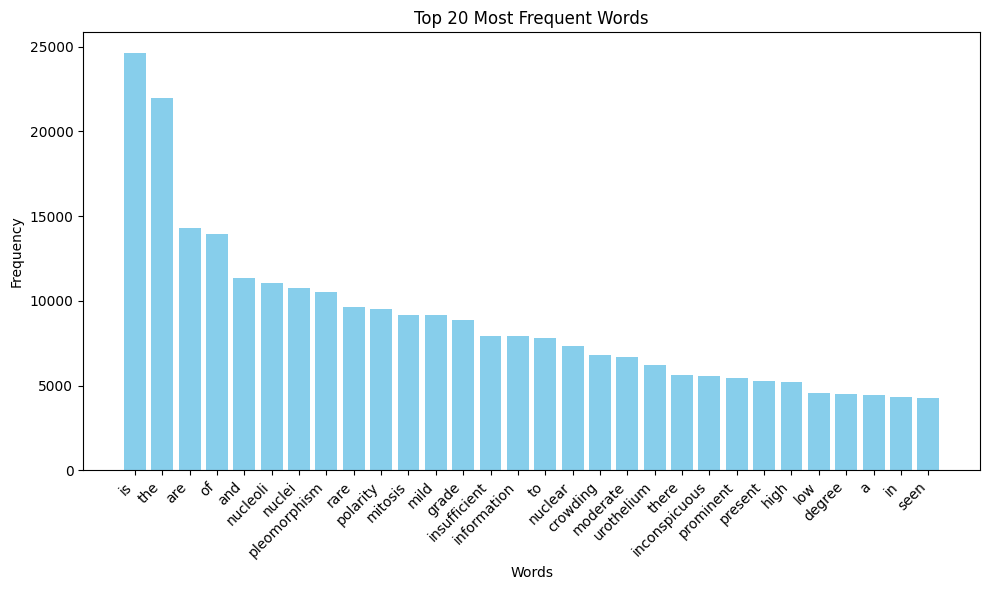

In [103]:
# Sort the dictionary by values to get the most frequent words
sorted_words = sorted(freq_map.items(), key=lambda x: x[1], reverse=True)

# Select top 20 most frequent words for plotting
top_words = dict(sorted_words[:30])

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_words.keys(), top_words.values(), color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [104]:
print(freq_map)

{'mild': 9141, 'pleomorphism': 10520, 'is': 24613, 'present': 5274, 'there': 5621, 'are': 14307, 'no': 2721, 'signs': 400, 'of': 13945, 'crowding': 6781, 'in': 4353, 'the': 21957, 'nuclei': 10772, 'polarity': 9510, 'along': 520, 'basement': 520, 'membrane': 520, 'negligibly': 1045, 'lost': 4160, 'mitosis': 9149, 'rare': 9621, 'have': 1846, 'inconspicuous': 5584, 'nucleoli': 11045, 'normal': 3592, 'nuclear': 7340, 'features': 2674, 'show': 3613, 'pictured': 409, 'exhibit': 409, 'not': 3155, 'exceedingly': 3853, 'and': 11374, 'limited': 2353, 'only': 1957, 'to': 7791, 'basal': 1957, 'layer': 1957, 'urothelium': 6206, 'retain': 590, 'a': 4421, 'cytologic': 2588, 'atypia': 2588, 'appears': 1952, 'be': 3847, 'absent': 1808, 'slight': 1474, 'variability': 2582, 'size': 2582, 'shape': 2582, 'outline': 2582, 'consistent': 2582, 'with': 2582, 'normally': 423, 'crowded': 3859, 'completely': 1895, 'toward': 2897, 'surface': 2897, 'visible': 1896, 'prominent': 5461, 'observed': 3240, 'or': 1896, '

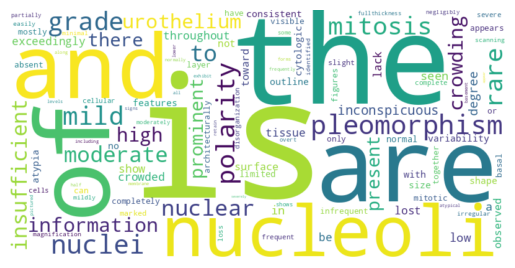

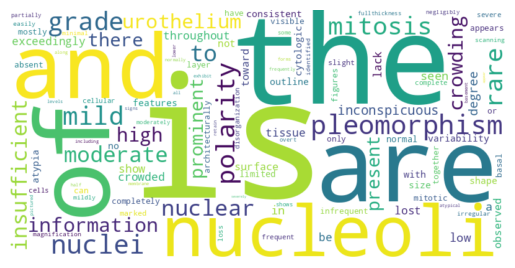

In [108]:
# text = " ".join([(k + " ")*v for k,v in freq_map.items()])

# # Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(freq_map)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

keys_to_remove = ['is','are','of','the','a','in']

# lower max_font_size
wordcloud = WordCloud(width=800, height=400, background_color='white')
wordcloud.generate_from_frequencies(freq_map)
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



In [94]:
caption = "Mild pleomorphism and cytologic atypia is present. There are no signs of crowding in the nuclei."
words = word_list_from_cap(caption)
# words = caption_no_punctuation.split()
print(words)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

